# Analysis of Kr data. Run 2980

In [3]:
from __future__ import print_function
import tables as tb
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import copy
import glob
import os

import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm
import Core.sensorFunctions as sns
import Core.fitFunctions as fit
import Core.tblFunctions as tbl

import Database.loadDB as DB

matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8) # Bigger plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

This notebook has been run last on 29/11/2016 at 14:27:02.


In [4]:
sipmdf = DB.DataSiPM()

In [10]:
t0 = time.time()
folder = "/Users/Gonzalo/github/IC/data/DATA/run_2980/"
pmaps = []
max_evt = 100000#np.inf
nevt = 0
for i, filename in enumerate(glob.glob(folder+"*.h5")):
    print(i, filename)
    with tb.open_file(filename) as h5f:
        pmaptbl = h5f.root.PMAPS.PMaps
        pmaps_ = [tbl.read_pmap(pmaptbl, ievt) for ievt in range(tbl.get_nofevents(pmaptbl, "event"))]
        pmaps.extend(pmaps_)
        nevt += len(pmaps_)
        if nevt > max_evt:
            break
print("Total number of pmaps:", len(pmaps))
pmaps = np.array(pmaps, dtype=object)
print(time.time()-t0)

0 /Users/Gonzalo/github/IC/data/DATA/run_2980/pmaps_run_2980.gdc1next.000.next1el_2980.root.h5
1 /Users/Gonzalo/github/IC/data/DATA/run_2980/pmaps_run_2980.gdc1next.001.next1el_2980.root.h5
2 /Users/Gonzalo/github/IC/data/DATA/run_2980/pmaps_run_2980.gdc1next.002.next1el_2980.root.h5
3 /Users/Gonzalo/github/IC/data/DATA/run_2980/pmaps_run_2980.gdc1next.003.next1el_2980.root.h5
4 /Users/Gonzalo/github/IC/data/DATA/run_2980/pmaps_run_2980.gdc1next.004.next1el_2980.root.h5
5 /Users/Gonzalo/github/IC/data/DATA/run_2980/pmaps_run_2980.gdc1next.005.next1el_2980.root.h5
6 /Users/Gonzalo/github/IC/data/DATA/run_2980/pmaps_run_2980.gdc1next.006.next1el_2980.root.h5
7 /Users/Gonzalo/github/IC/data/DATA/run_2980/pmaps_run_2980.gdc1next.007.next1el_2980.root.h5
8 /Users/Gonzalo/github/IC/data/DATA/run_2980/pmaps_run_2980.gdc1next.008.next1el_2980.root.h5
9 /Users/Gonzalo/github/IC/data/DATA/run_2980/pmaps_run_2980.gdc1next.009.next1el_2980.root.h5
10 /Users/Gonzalo/github/IC/data/DATA/run_2980/pma

# Event selection

### A few plots about the number of peaks

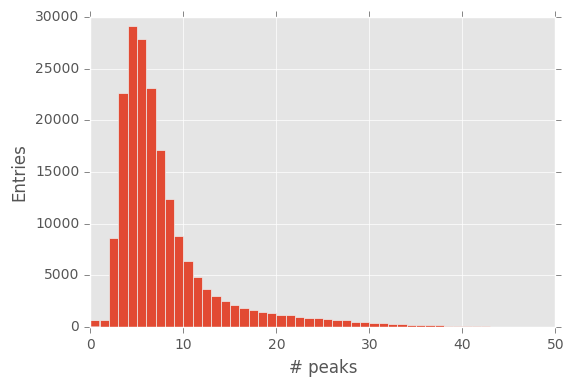

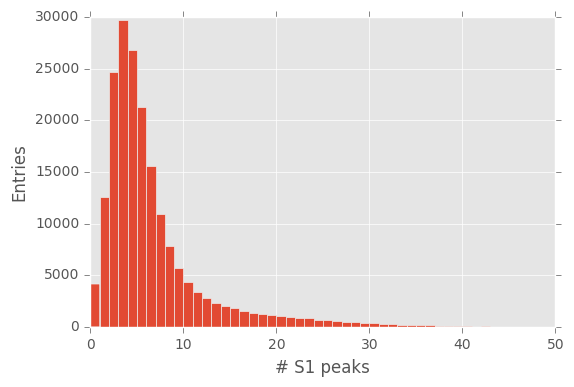

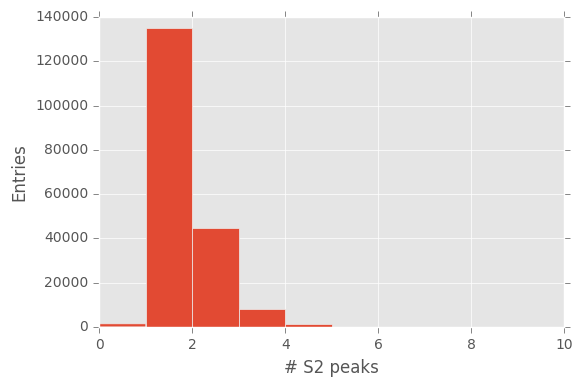

In [151]:
h = plt.hist([len(pmap.peaks) for pmap in pmaps], 50, range=(0,50))
plt.xlabel("# peaks")
plt.ylabel("Entries")

plt.figure()
h = plt.hist([len(pmap.get("S1")) for pmap in pmaps], 50, range=(0,50))
plt.xlabel("# S1 peaks")
plt.ylabel("Entries")

plt.figure()
h = plt.hist([len(pmap.get("S2")) for pmap in pmaps], 10, range=(0,10))
plt.xlabel("# S2 peaks")
plt.ylabel("Entries")

In [154]:
h[0][1]*100./h[0].sum()

70.808973773092333

#### The number of S1s is huge. But the number of S2s is reasonable. Placing a cut to select only those events with exactly one S2 and some S1 means reducing the sample size to 70%

In [166]:
selection = np.array([len(pmap.get("S1"))>0 and len(pmap.get("S2"))==1 for pmap in pmaps], dtype=bool)

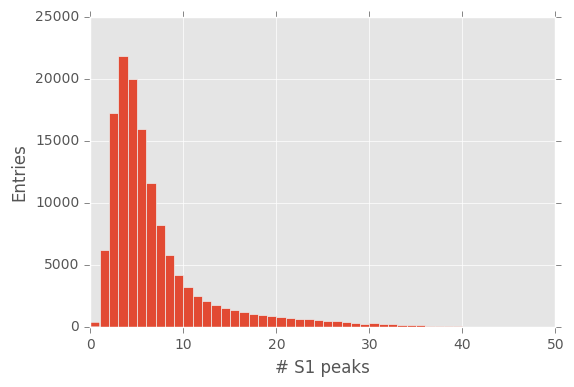

In [167]:
plt.figure()
h = plt.hist([len(pmap.get("S1")) for pmap in pmaps[selection]], 50, range=(0,50))
plt.xlabel("# S1 peaks")
plt.ylabel("Entries")

#### The number of S1s has not been reduced much after this selection. Lets look at the integral of the peaks.

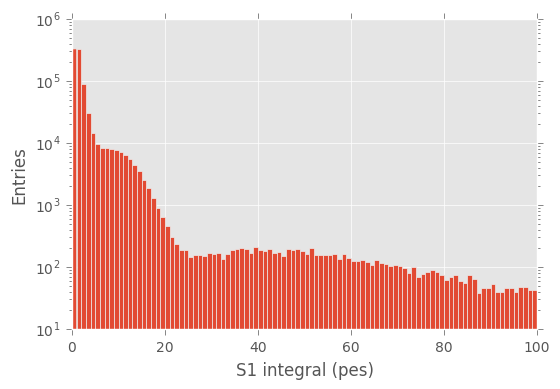

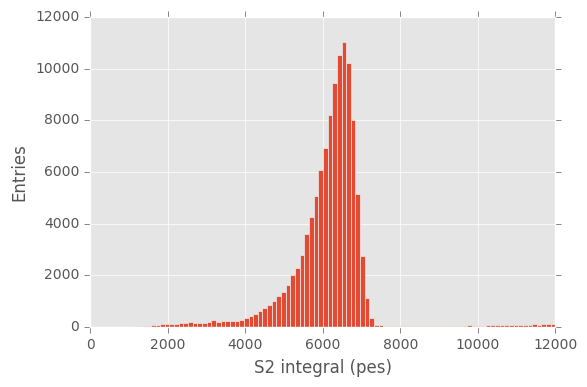

In [168]:
h = plt.hist([peak.cathode_integral for pmap in pmaps[selection] for peak in pmap.get("S1")], 100, range=(0, 100))
plt.xlabel("S1 integral (pes)")
plt.ylabel("Entries")
plt.yscale("log")

plt.figure()
h = plt.hist([peak.cathode_integral for pmap in pmaps[selection] for peak in pmap.get("S2")], 100, range=(0, 12000))
plt.xlabel("S2 integral (pes)")
plt.ylabel("Entries")
#plt.yscale("log")
pass

#### There is clearly somrething wrong with the integral of the S1 peaks. S2s, however, look pretty good. We only need to place a soft cut (4000-7700 pes) to take a clean sample of the Kr peak.

In [169]:
selection = np.array([len(pmap.get("S1"))>0 and len(pmap.get("S2"))==1 and 4000 < pmap.get("S2")[0].cathode_integral < 7800 for pmap in pmaps], dtype=bool)

#### The width of the S2 peaks is also a important feature

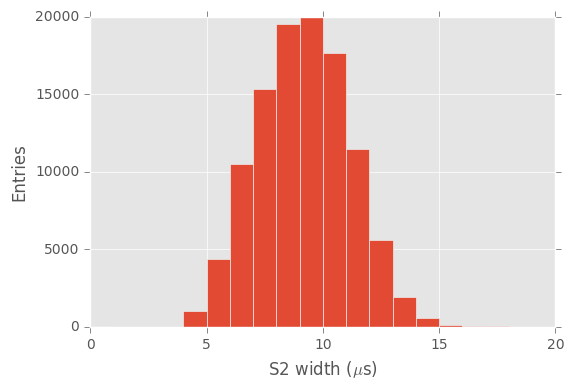

In [172]:
h = plt.hist([peak.width for pmap in pmaps[selection] for peak in pmap.get("S2")], 20, range=(0,20))
plt.xlabel("S2 width ($\mu$s)")
plt.ylabel("Entries")
pass

#### There are some events with wrong width. A cut to take events with less than 15 $\mu$s is enough.

In [175]:
selection = np.array([len(pmap.get("S1"))>0 and len(pmap.get("S2"))==1 and 4000 < pmap.get("S2")[0].cathode_integral < 7800 and pmap.get("S2")[0].width<15 for pmap in pmaps], dtype=bool)

#### The maximum height among S1 peaks may have something to say...

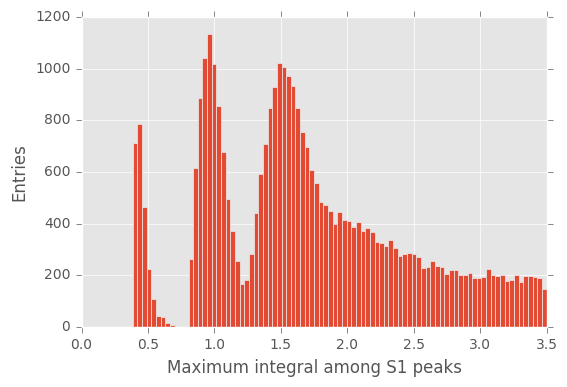

In [178]:
h = plt.hist([max(peak.cathode_integral for peak in pmap.get("S1")) for pmap in pmaps[selection]], 100, range=(0,3.5) )
plt.xlabel("Maximum integral among S1 peaks")
plt.ylabel("Entries")
pass

#### There is a clear structure here but it seems that the *real* S1s are those of the peaks in the middle (from a dummy calculation, I've got about 1-1.2 pes for the Kr's S1)

In [179]:
selection = np.array([len(pmap.get("S1"))>0 and len(pmap.get("S2"))==1 and 4000 < pmap.get("S2")[0].cathode_integral < 7800 and pmap.get("S2")[0].width<15 and 0.8 < max(peak.cathode_integral for peak in pmap.get("S1")) < 1.25 for pmap in pmaps], dtype=bool)

#### Let's see how are the S1s distributed

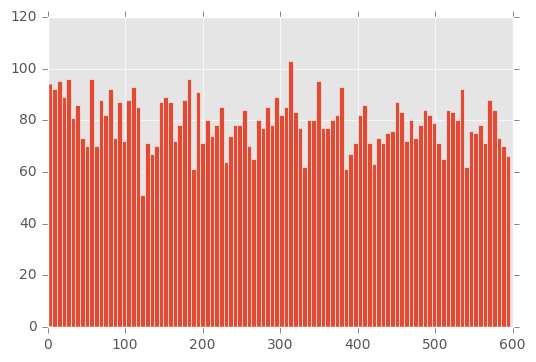

In [183]:
h = plt.hist([pmap.get("S1")[np.argmax([peak.cathode_integral for peak in pmap.get("S1")])].peakmax[0] for pmap in pmaps[selection]], 100)

#### Quite uniform. Now the S2s

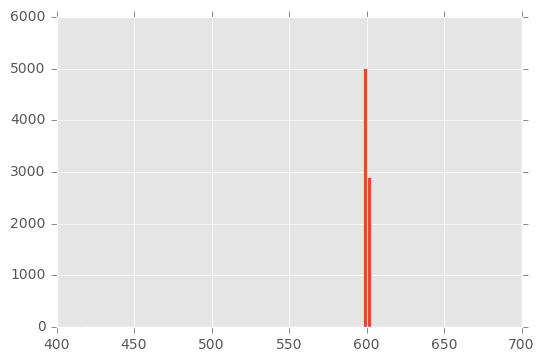

In [184]:
h = plt.hist([pmap.get("S2")[0].peakmax[0] for pmap in pmaps[selection]], 100)

#### The S2s are always at 600 $\mu$s. A feature caused by the trigger configuration.

### Since I am happy with that, I will formalize the selection for Kr events:

In [73]:
def Kr_selection(pmap):
    s1s = pmap.get("S1")
    s2s = pmap.get("S2")
    if len(s1s) == 0 or not (0.8 < max(p.cathode_integral for p in s1s) < 1.25):
        return False
    if len(s2s) != 1 or not (4000 < s2s[0].cathode_integral < 7800):
        return False
    if s2s[0].width > 15.:
        return False
    return True

In [74]:
selection = np.array(map(Kr_selection, pmaps), dtype=bool)

# Raw spectrum fitted to a gaussian

In [75]:
E = np.array([pmap.E for pmap in pmaps[selection]])
h = plt.hist(E, 100)
x, y = h[1][:-1], h[0]
x, y = x[x>5500], y[x>5500]
f, v, e = fit.fit("gauss", x, y, (1e3, 6500., 300.))
plt.plot(x, f(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
plt.gcf().set_size_inches(9,6)
print("fit values:", v)
print("FWHM resolution: {}% => {}% @ Qbb".format(235.*v[2]/v[1], 235.*v[2]/v[1]*(41.5/2458.)**0.5))

plt.show()
plt.figure()
E = np.array([pmap.E for pmap in pmaps[selection] if pmap.r < 50.])
h = plt.hist(E, 100)
x, y = h[1][:-1], h[0]
f, v, e = fit.fit("gauss", x, y, (1e3, 6500., 300.))
plt.plot(x, f(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
plt.gcf().set_size_inches(9,6)
print("fit values:", v)
print("FWHM resolution: {}% => {}% @ Qbb".format(235.*v[2]/v[1], 235.*v[2]/v[1]*(41.5/2458.)**0.5))

AttributeError: PMap instance has no attribute 'E'

#### Geometrical effects play a big role here and therefore the ER is not great (2%). But still, we can measures our "intrinsic resolution" taking centered events.  This way we reach 1.1% FWHM @ $Q_{\beta\beta}$... Not bad!

## Let's set the t0 and z coordinates for these events

In [188]:
for pmap in pmaps[selection]:
    S1s = pmap.get("S1")
    S2 = pmap.get("S2")[0]
    largestS1 = S1s[np.argmax([peak.cathode_integral for peak in S1s])]
    pmap.t0 = largestS1.peakmax[0]
    pmap.z = S2.peakmax[0] - pmap.t0
    pmap.E = S2.cathode_integral

### A plot of the distribution of the events in z

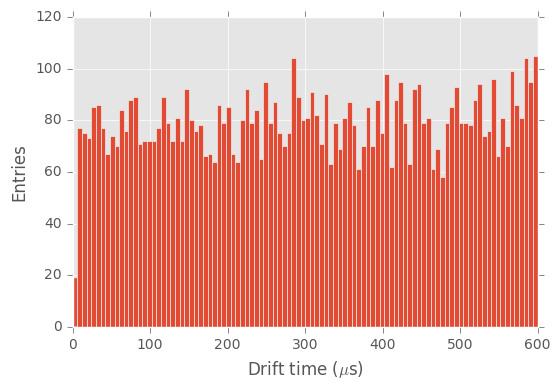

In [187]:
h = plt.hist([pmap.z for pmap in pmaps[selection]], 100, range=(0,600))
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("Entries")

#### As expected. Let's see how the energy drops in z due to attachment

fit values: [  6.24577726e+03  -8.14994024e+10]


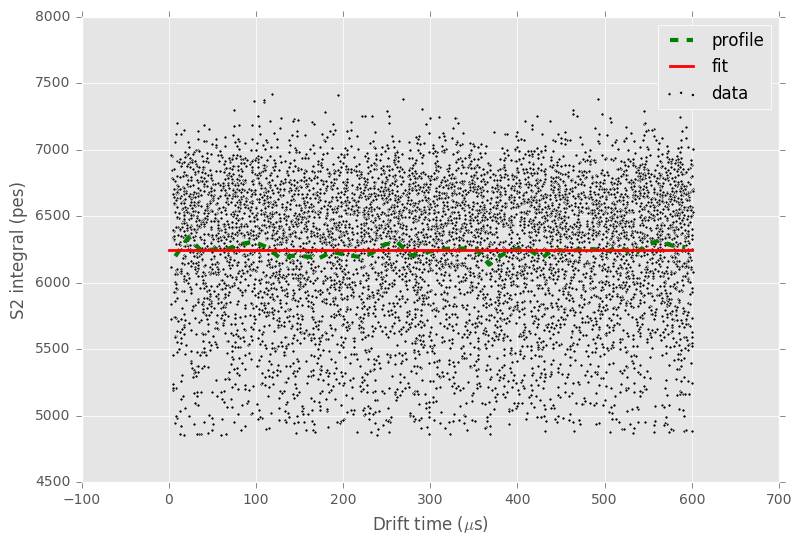

In [280]:
z, E = map(np.array, zip(*[(pmap.z, pmap.E) for pmap in pmaps[selection]]))
z, E = z[abs(E-np.mean(E))<np.std(E)*2], E[abs(E-np.mean(E))<np.std(E)*2]
zp, Ep, Eerr = fit.profileX(z, E, 40, (0, 600))
f, v, e = fit.fit("expo", zp, Ep, (6500., -1e4), sigma=Eerr)
plt.scatter(z, E, marker=".", facecolor="k", label="data")
plt.plot(zp, Ep, "g--", linewidth=3, label="profile")
x = np.linspace(0., 600., 1000)
plt.plot(x, f(x), "r-", label="fit", linewidth=2)
#plt.ylim((0, plt.ylim()[1]))
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("S2 integral (pes)")
plt.legend()
plt.gcf().set_size_inches(9,6)

print("fit values:", v)

#### Not much effect, let's limit to the center:

In [281]:
def baricenter(pmap, sipmdf, thrs=0.25):
    anode = np.concatenate([peak.anode for peak in pmap])
    q = np.nansum(anode, axis=0)
    selection = q > np.max(q) * thrs
    q = q[selection]
    if q.sum() < 1.:
        return 1e4, 1e4
    x = np.average(sipmdf["X"].values[selection], weights=q)
    y = np.average(sipmdf["Y"].values[selection], weights=q)
    return x, y

def centered(pmap, sipmdf, rmax=100., thrs=0.25):
    x, y = baricenter(pmap, sipmdf, thrs)
    return x**2 + y**2 < rmax**2

fit values: [   6693.80604167 -176720.41390129]


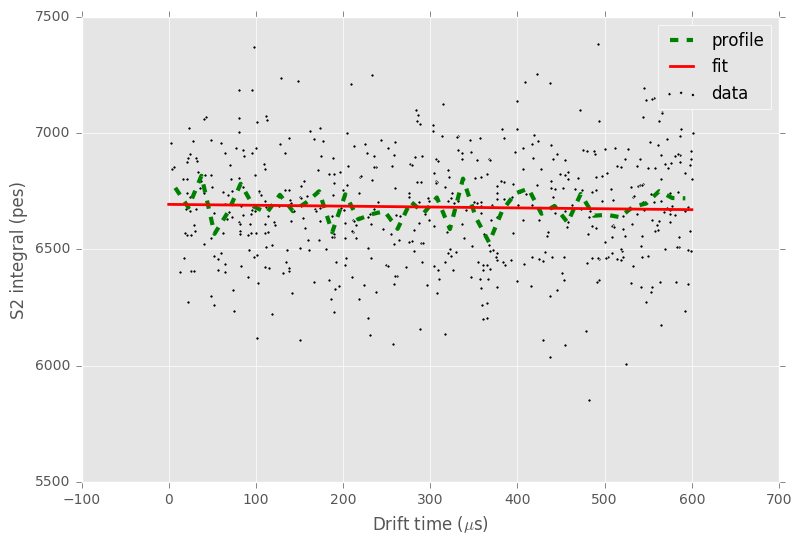

In [282]:
z, E = map(np.array, zip(*[(pmap.z, pmap.E) for pmap in pmaps[selection] if centered(pmap, sipmdf, 50., 0.5)]))
z, E = z[abs(E-np.mean(E))<np.std(E)*2], E[abs(E-np.mean(E))<np.std(E)*2]
zp, Ep, Eerr = fit.profileX(z, E, 40, (0, 600))
f, v, e = fit.fit("expo", zp, Ep, (6500., -1e4), sigma=Eerr)
plt.scatter(z, E, marker=".", facecolor="k", label="data")
plt.plot(zp, Ep, "g--", linewidth=3, label="profile")
x = np.linspace(0., 600., 1000)
plt.plot(x, f(x), "r-", label="fit", linewidth=2)
#plt.ylim((0, plt.ylim()[1]))
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("S2 integral (pes)")
plt.legend()
print("fit values:", v)
plt.gcf().set_size_inches(9,6)

att_func = copy.copy(f)
att_corr = lambda x: att_func(0.)/att_func(x)

#### A bit more, but the lifetime is still much larger than expected (176 ms). The effect on resolution will therefore be small.

fit values: [ 246201.40927217    6387.40195806     436.69618191]
FWHM resolution: 16.0665640619% => 2.08764244958% @ Qbb


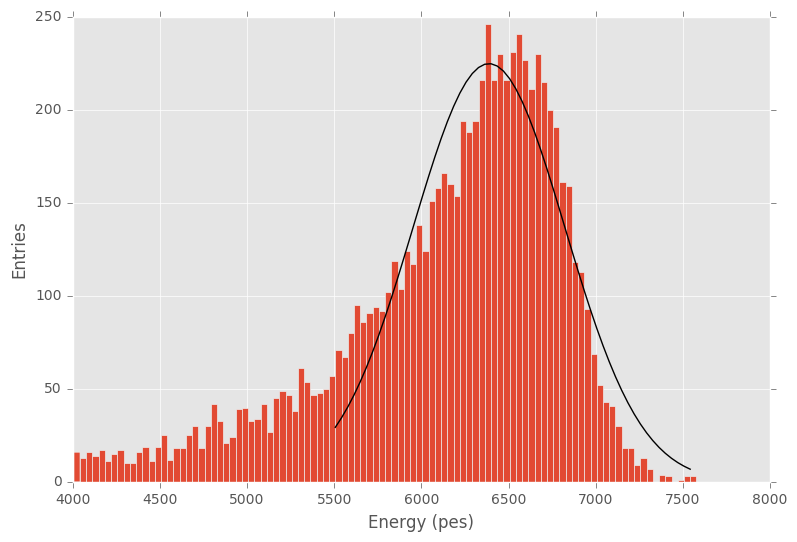

fit values: [ 19687.71436775   6673.60194701    246.97385049]
FWHM resolution: 8.69678103748% => 1.13003434951% @ Qbb


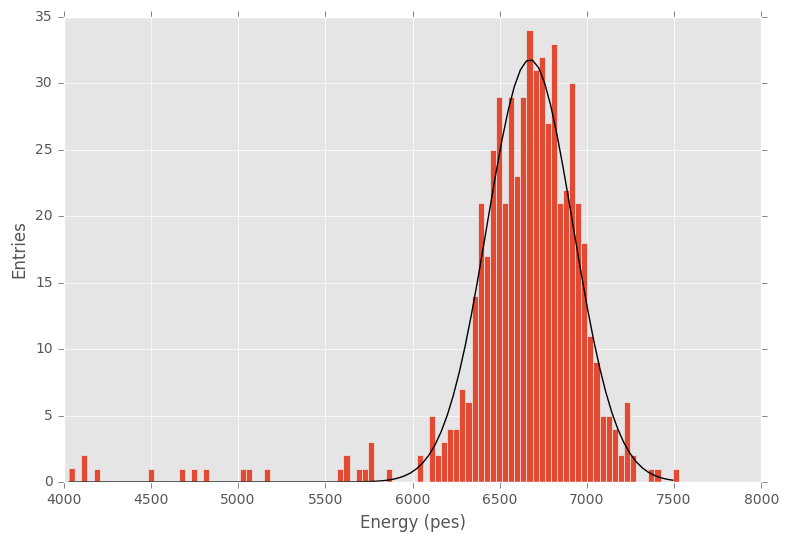

In [296]:
E = np.array([pmap.E * att_corr(pmap.z) for pmap in pmaps[selection]])
h = plt.hist(E, 100)
x, y = h[1][:-1], h[0]
x, y = x[x>5500], y[x>5500]
f, v, e = fit.fit("gauss", x, y, (1e3, 6500., 300.))
plt.plot(x, f(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
plt.gcf().set_size_inches(9,6)
print("fit values:", v)
print("FWHM resolution: {}% => {}% @ Qbb".format(235.*v[2]/v[1], 235.*v[2]/v[1]*(41.5/2458.)**0.5))
plt.show()

plt.figure()
E = np.array([pmap.E * att_corr(pmap.z) for pmap in pmaps[selection] if pmap.r < 50.])
h = plt.hist(E, 100)
x, y = h[1][:-1], h[0]
f, v, e = fit.fit("gauss", x, y, (1e3, 6500., 300.))
plt.plot(x, f(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
plt.gcf().set_size_inches(9,6)
print("fit values:", v)
print("FWHM resolution: {}% => {}% @ Qbb".format(235.*v[2]/v[1], 235.*v[2]/v[1]*(41.5/2458.)**0.5))

## Let's move to geometrical effects

In [268]:
for pmap in pmaps[selection]:
    pmap.x, pmap.y = baricenter(pmap, sipmdf, 0.5)
    pmap.r = (pmap.x**2 + pmap.y**2)**0.5

#### First, the XY distribution of the events

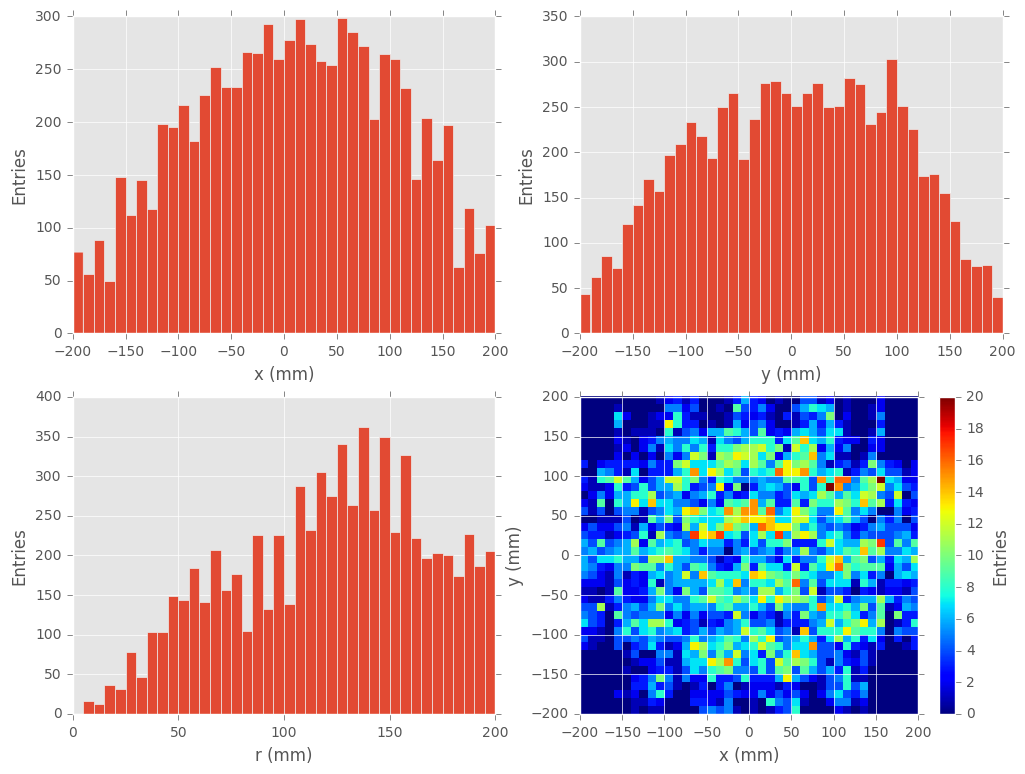

In [269]:
x, y, r = map(np.array, zip(*[(pmap.x, pmap.y, pmap.r) for pmap in pmaps[selection]]))

plt.subplot(2,2,1)
h = plt.hist(x, 40, range=(-200., 200.))
plt.xlabel("x (mm)")
plt.ylabel("Entries")

plt.subplot(2,2,2)
h = plt.hist(y, 40, range=(-200., 200.))
plt.xlabel("y (mm)")
plt.ylabel("Entries")

plt.subplot(2,2,3)
h = plt.hist(r, 40, range=(0., 200.))
plt.xlabel("r (mm)")
plt.ylabel("Entries")

plt.subplot(2,2,4)
h = plt.hist2d(x, y, 40, range=((-200., 200.), (-200., 200.)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar().set_label("Entries")

plt.gcf().set_size_inches(12, 9)

#### It seems that there are some structures present, but let's say it is good enough. We are interested in energy vs r.

fit values: [  6.52659658e+03   4.05605702e+00  -4.68244647e-02]


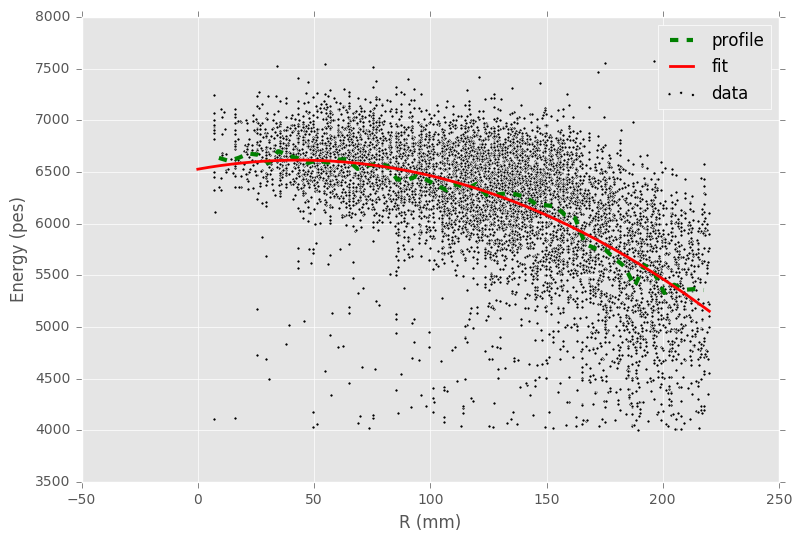

In [285]:
r, E = map(np.array, zip(*[(pmap.r, pmap.E * att_corr(pmap.z)) for pmap in pmaps[selection]]))
r, E = r[r<220.], E[r<220.]
rp, Ep, Ep_err = fit.profileX(r, E, 50)

p = plt.scatter(r, E, marker=".", facecolors="k", label="data")
p = plt.plot(rp, Ep, "g--", linewidth=3, label="profile")

f, v, e = fit.fit("polynom", r, E, (6000., -1e-2, -1e-4))
print("fit values:", v)
x = np.linspace(0., 220., 1000)
y = f(x)
plt.plot(x, y, "r-", linewidth=2, label="fit")
plt.xlabel("R (mm)")
plt.ylabel("Energy (pes)")
plt.legend()
plt.gcf().set_size_inches(9,6)

geo_func = copy.copy(f)
geo_corr = lambda x: geo_func(0.)/geo_func(x)

#### Huge effect on r. Lets see how is the spectrum is affected.

fit values: [  7.63074273e+05   6.56992982e+03   4.17397948e+02]
FWHM resolution: 14.9299186329% => 1.93995005943% @ Qbb


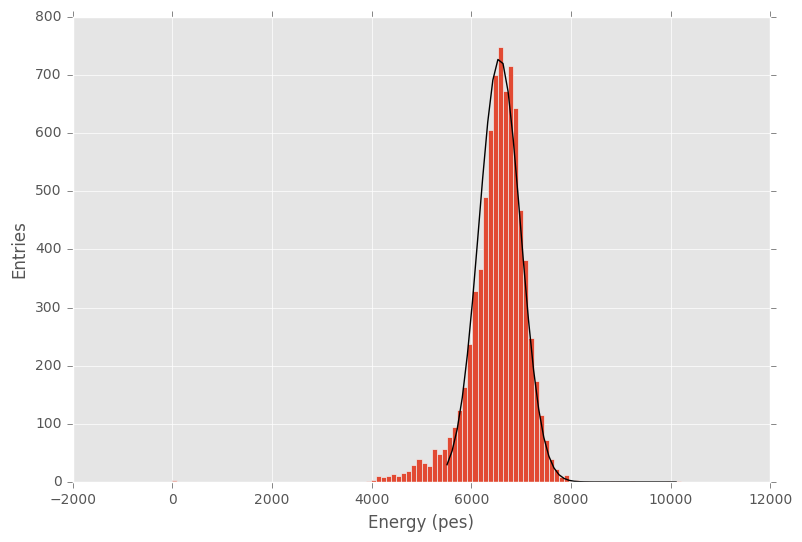

fit values: [ 19386.69484289   6590.59028482    243.1169933 ]
FWHM resolution: 8.66879762744% => 1.12639826687% @ Qbb


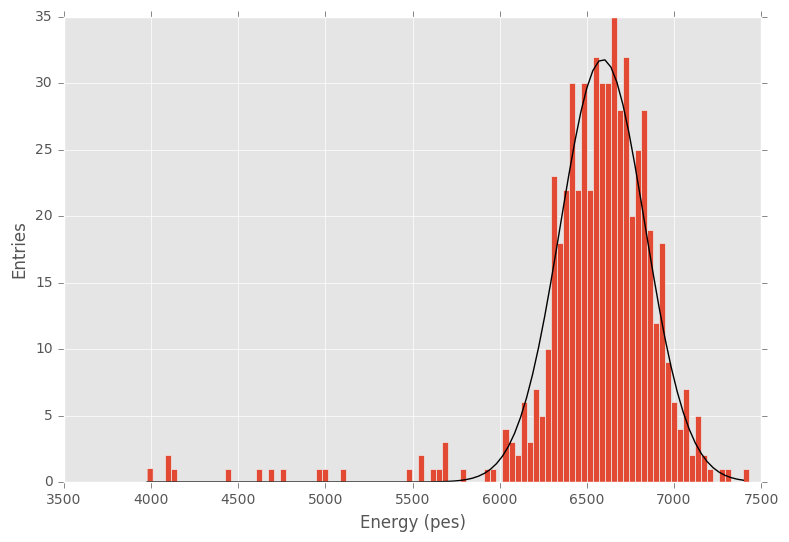

In [291]:
E = np.array([pmap.E * att_corr(pmap.z) * geo_corr(pmap.r) for pmap in pmaps[selection]])
h = plt.hist(E, 100)
x, y = h[1][:-1], h[0]
x, y = x[x>5500], y[x>5500]
f, v, e = fit.fit("gauss", x, y, (1e3, 6500., 300.))
plt.plot(x, f(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
plt.gcf().set_size_inches(9,6)
print("fit values:", v)
print("FWHM resolution: {}% => {}% @ Qbb".format(235.*v[2]/v[1], 235.*v[2]/v[1]*(41.5/2458.)**0.5))
plt.show()

plt.figure()
E = np.array([pmap.E * att_corr(pmap.z) * geo_corr(pmap.r) for pmap in pmaps[selection] if pmap.r < 50.])
h = plt.hist(E, 100)
x, y = h[1][:-1], h[0]
f, v, e = fit.fit("gauss", x, y, (1e3, 6500., 300.))
plt.plot(x, f(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
plt.gcf().set_size_inches(9,6)
print("fit values:", v)
print("FWHM resolution: {}% => {}% @ Qbb".format(235.*v[2]/v[1], 235.*v[2]/v[1]*(41.5/2458.)**0.5))

#### Funnily enough, it doesn't seem to improve energy resolution. This is caused by the large dispersion in energy for large radii.

fit values: [  6.52679141e+03   4.81883526e-03  -4.47198825e-05]


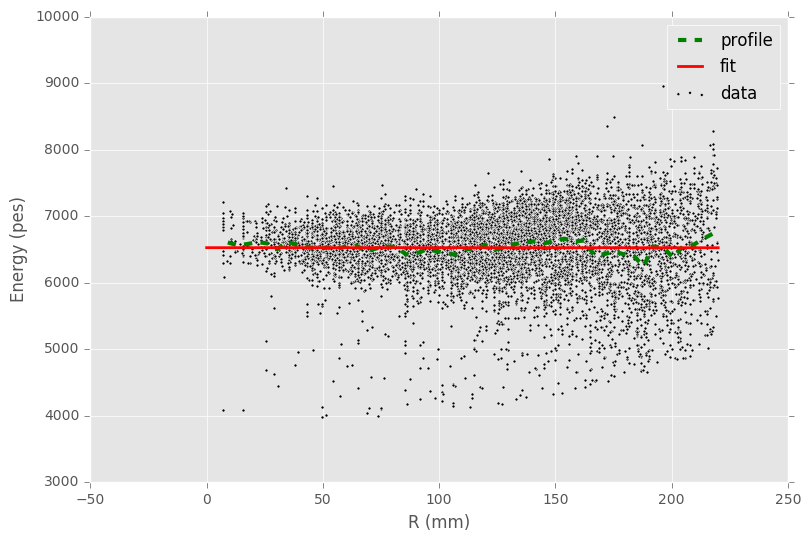

In [297]:
r, E = map(np.array, zip(*[(pmap.r, pmap.E * att_corr(pmap.z) * geo_corr(pmap.r)) for pmap in pmaps[selection]]))
r, E = r[r<220.], E[r<220.]
rp, Ep, Ep_err = fit.profileX(r, E, 50)

p = plt.scatter(r, E, marker=".", facecolors="k", label="data")
p = plt.plot(rp, Ep, "g--", linewidth=3, label="profile")

f, v, e = fit.fit("polynom", r, E, (6000., -1e-2, -1e-4))
print("fit values:", v)
x = np.linspace(0., 220., 1000)
y = f(x)
plt.plot(x, y, "r-", linewidth=2, label="fit")
plt.xlabel("R (mm)")
plt.ylabel("Energy (pes)")
plt.legend()
plt.gcf().set_size_inches(9,6)

geo_func = copy.copy(f)
geo_corr = lambda x: geo_func(0.)/geo_func(x)

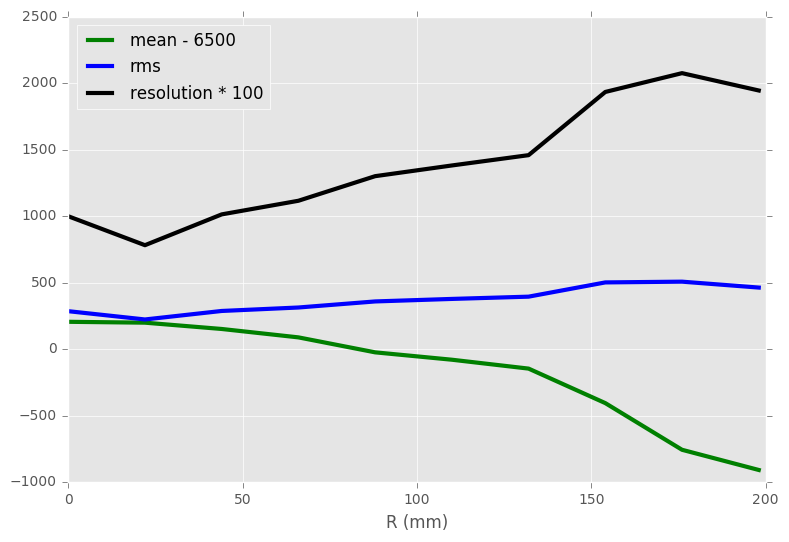

In [334]:
r, E = map(np.array, zip(*[(pmap.r, pmap.E * att_corr(pmap.z) * geo_corr(pmap.r)) for pmap in pmaps[selection]]))
r, E = r[r<220.], E[r<220.]

mean, rms, reso = [], [], []
for i in range(10):
    x, y = fit.projectionY(r, E, 50, (5000, 7500), (i*22., (i+1)*22.))
    f, v, e = fit.fit("gauss", x, y, (1000., 6500., 400.))
    mean.append(v[1] - 6500)
    rms.append(v[2])
    reso.append(235.*v[2]/v[1] * 100)

p = plt.plot(np.linspace(0, 220, 10, endpoint=False), mean, "g-", linewidth=3, label="mean - 6500")
p = plt.plot(np.linspace(0, 220, 10, endpoint=False), rms, "b-", linewidth=3, label="rms")
p = plt.plot(np.linspace(0, 220, 10, endpoint=False), reso, "k-", linewidth=3, label="resolution * 100")

plt.xlabel("R (mm)")
plt.legend(loc='upper left')
plt.gcf().set_size_inches(9,6)

#### This makes pretty clear that we are not getting better resolution because the standart deviation increases while the mean decreases.

# Finally let's try to create a Kr energy map

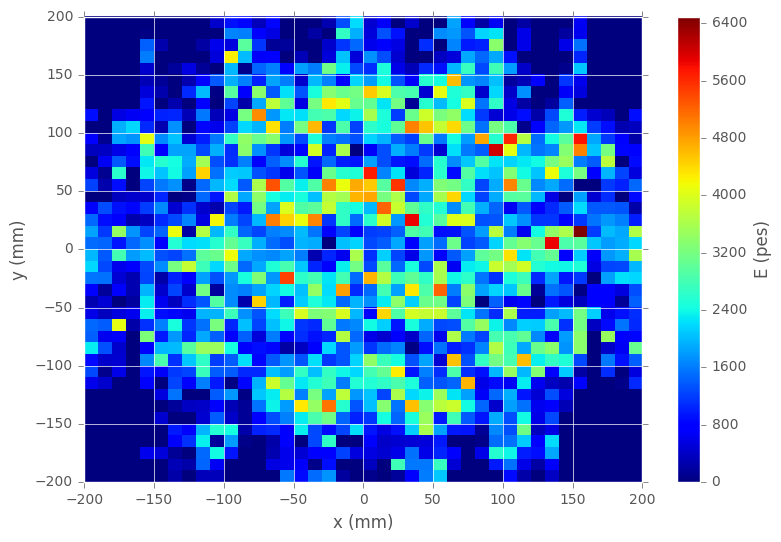

In [335]:
x, y, E = map(np.array, zip(*[(pmap.x, pmap.y, pmap.z) for pmap in pmaps[selection]]))
x, y, E = x[x<1000], y[x<1000], E[x<1000]
h = plt.hist2d(x, y, 40, range=((-200., 200.), (-200., 200.)), weights=E)
plt.gcf().set_size_inches(9,6)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar().set_label("E (pes)")

#### The same structures show up in the energy map, which is an indication that there some problem with the tracking plane.

### Lets see the S1/S2 anticorrelation

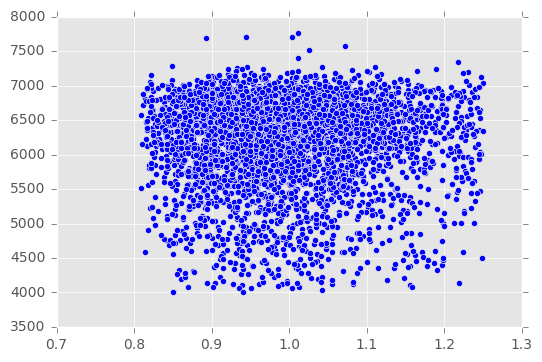

In [13]:
s1q, s2q = [], []
for pmap in pmaps[selection]:
    S1s = pmap.get("S1")
    s1q.append(np.max([peak.cathode_integral for peak in S1s]))
    s2q.append(pmap.get("S2")[0].cathode_integral)
    
plt.scatter(s1q, s2q)

In [30]:
def poisson(l, k):
    return np.power(l,k) * np.exp(-l)/np.array(map(np.math.factorial,k))

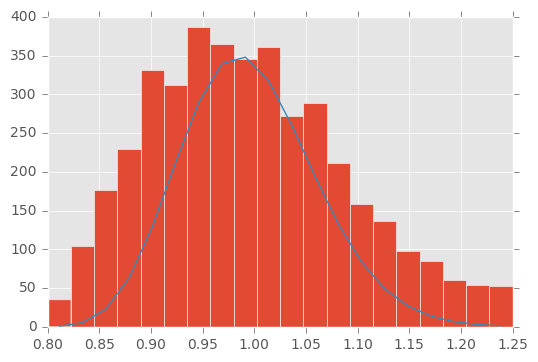

In [59]:
h = plt.hist(s1q, 20, range=(0.8, 1.25))
p = plt.plot(0.8 + 0.0225*(np.arange(20)+0.5), poisson(8.2, np.arange(20))*2500)

In [71]:
def p(x, scale, mean):
    return scale * poisson(mean, ((x-0.8)//0.00225).astype(int))

In [72]:
scale, mean = fit.optim.curve_fit(p, h[1][:-1], h[0], (3000., 3.2))[0]

OverflowError: long int too large to convert to float

In [ ]:
h = plt.hist(s1q, 20, range=(0.8, 1.25))
p = plt.plot(0.8 + 0.0225*(np.arange(20)+0.5), scale * poisson(mean, np.arange(20)))